In [1]:
import re
import warnings
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

warnings.filterwarnings('ignore')

# Data Cleaning

In [2]:
df_sbuzz = pd.read_csv("syndata/Box Office/Recruitment x Box Office x Q1 2019 - Twitter.csv", sep="\t")
df_title = pd.read_csv("syndata/Box Office/Recruitment x Box Office x Q1 2019 - Titles Performace.csv", sep="\t")

In [3]:
df_sbuzz = df_sbuzz.drop(axis=1, labels=['Unnamed: 0'])
df_sbuzz['title'] = df_sbuzz['title'].str.lower()

df_title['Title'] = df_title['Title'].str.lower()

df_sbuzz['post_date'] = pd.to_datetime([datetime.datetime.strptime(x[0], '%Y-%m-%d').date() for x in list(df_sbuzz['post_date_time'].str.split('T'))])
df_sbuzz['post_time'] = [datetime.datetime.strptime(x[1].split('.')[0], '%H:%M:%S').time() for x in list(df_sbuzz['post_date_time'].str.split('T'))]

In [4]:
movie_dict = {}
c = 0

for i in df_sbuzz.index:
    if df_sbuzz.at[i, 'title'] not in movie_dict:
        c+=1
        movie_dict[df_sbuzz.at[i, 'title']] = c

for i in df_title.index:
    if df_title.at[i, 'Title'] not in movie_dict:
        c+=1
        movie_dict[df_title.at[i, 'Title']] = c
        
rev_movie_dict = {v:k for k, v in movie_dict.items()}

In [5]:
#movie_dict

In [6]:
# reformatting should be done better
for i in df_title.index:
    dates = df_title.at[i, 'Date']
    reg_date = re.sub("[.]|[ ]", "", dates)
    dt_list = []
    
    for d1 in reg_date.split('–'):   
        d1 = re.sub("Sept", "Sep", d1)
        m1 = ''
        if len(d1) > 3:
            month = m1.join(re.findall("[a-zA-Z]", d1))
            day = m1.join(re.findall("[0-9]", d1))

            s = '{} {} {}'.format(month, day, df_title.at[i, 'Year'])
            dt_list.append(datetime.datetime.strptime(s, '%b %d %Y').date())
            
        else:
            s = '{} {} {}'.format(month, d1, df_title.at[i, 'Year'])
            dt_list.append(datetime.datetime.strptime(s, '%b %d %Y').date())

    df_title.at[i, 'begin_date'] = dt_list[0]
    df_title.at[i, 'end_date'] = dt_list[1]

    new_range = []
    default_range = range(0, 7)
    wk_range = range(dt_list[0].weekday(), dt_list[1].weekday())
    
    if wk_range.start > wk_range.stop:
        k = wk_range.start
        for _ in range(len(default_range)):
            new_range.append(default_range[k % len(default_range)])
            k+=1
    else:
        new_range = list(wk_range)
    
    df_title.at[i, 'has_weekend'] = 5 in new_range or 6 in new_range
    df_title.at[i, 'nth_week_number'] = dt_list[0].isocalendar()[1]
    df_title.at[i, 'movie_id_t'] = int(movie_dict[df_title.at[i, 'Title']])
    df_title.at[i, 'gross_to_date_float'] = float(re.sub('[^\d.]', '', df_title.at[i, 'Gross-to-Date']))
    

In [7]:
for i in df_sbuzz.index:
    df_sbuzz.at[i, 'movie_id_s'] = int(movie_dict[df_sbuzz.at[i, 'title']])
    df_sbuzz.at[i, 'nth_week_number'] = df_sbuzz.at[i, 'post_date'].isocalendar()[1]
    df_sbuzz.at[i, 'is_influencer'] = df_sbuzz.at[i, 'user_followers_count'] > 10000

In [8]:
titles = list(df_title['movie_id_t'].unique())
titles_buzz =  list(df_sbuzz['movie_id_s'].unique())
len(set(titles).intersection(titles_buzz))

17

In [9]:
df_title.sample(3) 

,Title,Date,Year,Rank,Weekend Gross,Gross-to-Date,Week # of release,begin_date,end_date,has_weekend,nth_week_number,movie_id_t,gross_to_date_float
26,beauty and the beast,Apr. 20–23,2017,-,"$1,610,625","$33,760,557",5,2017-04-20,2017-04-23,True,16.0,1.0,33760557.0
127,star wars: the last jedi,Dec. 28–31,2017,2,"$4,825,920","$35,513,254",3,2017-12-28,2017-12-31,True,52.0,8.0,35513254.0
81,avengers: infinty war,May 17–20,2018,2,"$1,771,032","$42,973,959",4,2018-05-17,2018-05-20,True,20.0,26.0,42973959.0


In [10]:
df_sbuzz.sample(3)

,ID,title,post_link,post_date_time,post_content,user_name,user_bio,user_followers_count,user_followee_count,user_post_count,country,state,language,post_date,post_time,movie_id_s,nth_week_number,is_influencer
13669,1,black panther,http://twitter.com/garliquorice/status/9657120...,2018-02-19T22:17:51.000+0000,RT @DanaSchwartzzz “I would have seen Black Pa...,garliquorice,ur local wedgie-dealer and lunch money-stealer,130,205,6321,AUS,Victoria,en,2018-02-19,22:17:51,4.0,8.0,False
42598,8,coco,http://twitter.com/TomOCallan/status/932155273...,2017-11-19T07:55:10.000+0000,RT @inkmarksofsu Frankel x Monsun cross 🇯🇵🐴: S...,TomOCallan,bluddy gubmint,491,2042,12208,AUS,Queensland,en,2017-11-19,07:55:10,10.0,46.0,False
60760,16,bird box,http://twitter.com/monakhalifaxo/status/107809...,2018-12-27T01:24:11.000+0000,RT @jjessicataylorr Creature:”your man over he...,monakhalifaxo,its really not that deep ...Instagram: monakha...,2719,338,29427,AUS,Victoria,en,2018-12-27,01:24:11,16.0,52.0,False


-----------

# Analysis through feature engineering and visualization

In [11]:
plt.rcParams['figure.figsize'] = [16, 10]
sns.set(color_codes=True)

### Cumulative movie sales in the box office:

In [12]:
agg_cost = df_title.groupby(['Title']).sum()[['gross_to_date_float']].sort_values(
    by='gross_to_date_float', ascending=False)

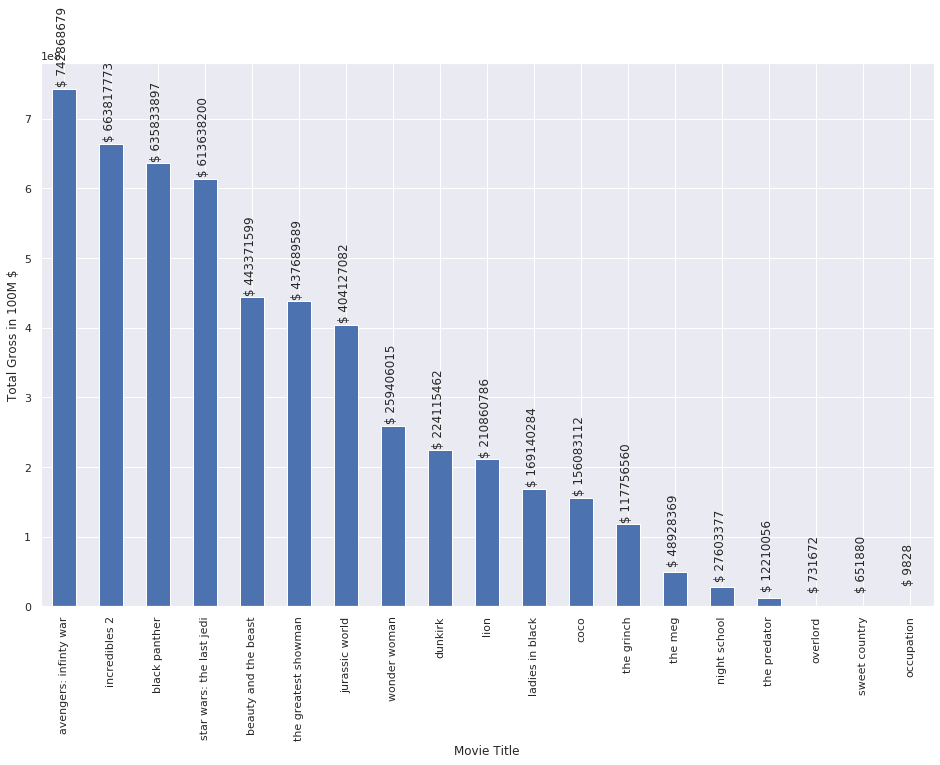

In [13]:
ax = agg_cost.plot(kind='bar', legend=False)
ax.set_xlabel("Movie Title")
ax.set_ylabel("Total Gross in 100M $")

for p in ax.patches:
    ax.annotate(' $ '+str(int(p.get_height())), (p.get_x(), p.get_height()), 
                ha = 'center', va = 'center', xytext = (10, 40), textcoords = 'offset points', rotation=90)

### Sales distributed across weeks

In [14]:
by_week = (df_title
            .groupby(['Title', 'Week # of release'])
            .size()
            .unstack())

by_nth_week = (df_title
              .groupby(['Title', 'nth_week_number'])
              .size()
              .unstack())

In [15]:
for idx in by_week.index:
    for col in by_week.columns:
        
        try:
            by_week.at[idx, col] = float(df_title[(df_title['Title']==idx) & (df_title['Week # of release']==col)]['gross_to_date_float'])
        except:
            by_week.at[idx, col] = np.nan
            
for idx in by_nth_week.index:
    for col in by_nth_week.columns:
        
        try:
            by_nth_week.at[idx, col] = float(df_title[(df_title['Title']==idx) & (df_title['nth_week_number']==col)]['gross_to_date_float'])
        except:
            by_nth_week.at[idx, col] = np.nan

In [16]:
# by_week.sample(3)
# by_nth_week.sample(3)

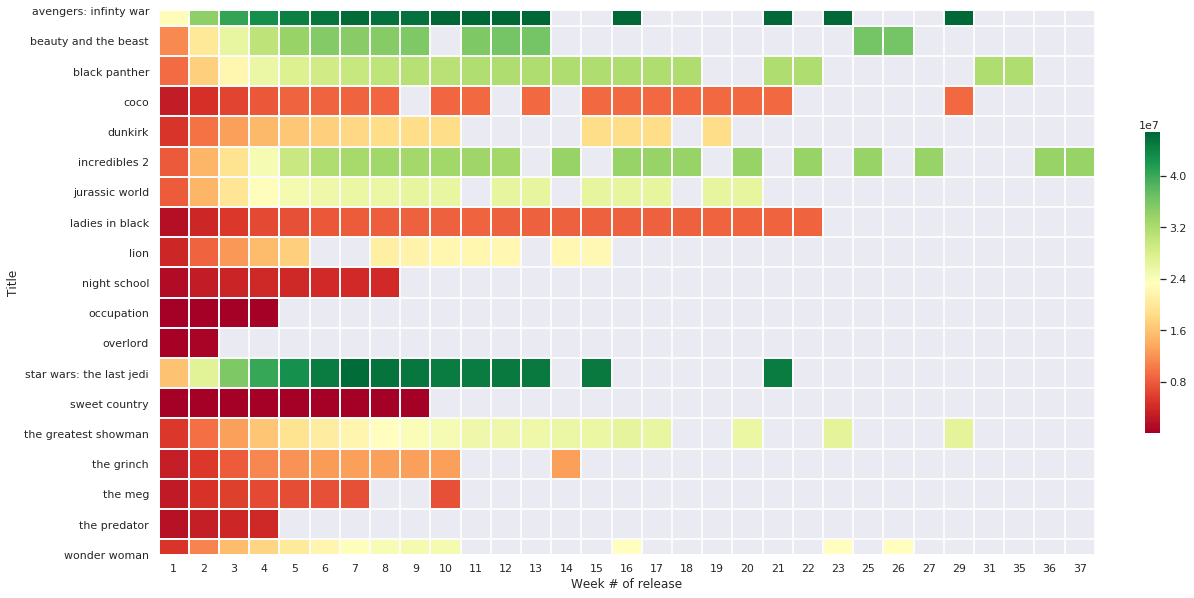

In [17]:
plt.figure(figsize=(18,10))
week_releases = sns.heatmap(
    by_week, 
    square=True, 
    cbar_kws={'fraction' : 0.015}, 
    cmap='RdYlGn',
    linewidth=1,
    linecolor="#fbfbfb"
)

# given box office sales for movies that have only performed good, i.e. sales keep increasing after every week

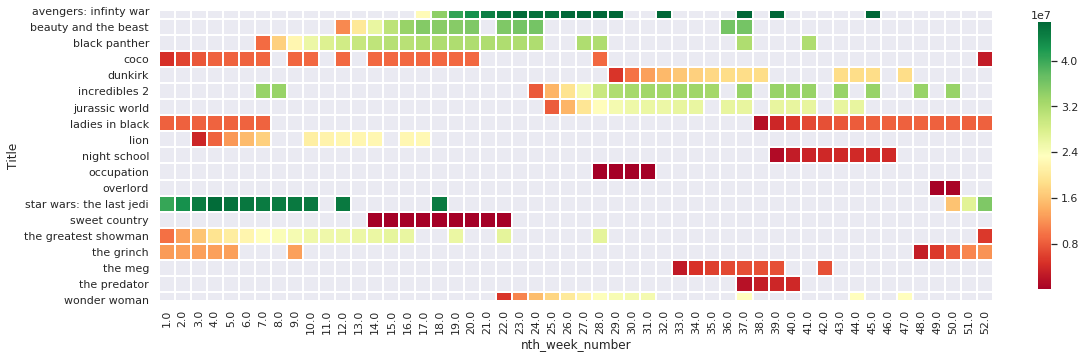

In [18]:
# perform same heatmap analysis for nth week of the year sales
nth_week_releases = sns.heatmap(
    by_nth_week, 
    square=True, 
    cbar_kws={'fraction' : 0.015}, 
    cmap='RdYlGn',
    linewidth=1 
)

### Do tweets effect sales?

In [19]:
tweets_per_movie_date = df_sbuzz.groupby(['movie_id_s', 'title', 'post_date']).size().unstack(1)

In [20]:
box_vs_tweets = df_title[['movie_id_t', 'Title', 'begin_date', 'end_date', 'gross_to_date_float']]

In [21]:
box_vs_tweets["tweets_received"] = 0

In [22]:
for m_id, time in tweets_per_movie_date.index:
    curr_df = box_vs_tweets[box_vs_tweets['movie_id_t']==m_id]
    for idx in curr_df.index:
        
        if curr_df.at[idx, 'begin_date'] < time < curr_df.at[idx, 'end_date']:
            box_vs_tweets.at[idx, 'tweets_received'] = tweets_per_movie_date.loc[(m_id, time), rev_movie_dict[m_id]]

        if curr_df.at[idx, 'begin_date'] > time:
            new_idx = len(box_vs_tweets)+1
            box_vs_tweets.at[new_idx, 'begin_date'] = time.date()
            box_vs_tweets.at[new_idx, 'end_date'] = time.date()
            box_vs_tweets.at[new_idx, 'Title'] = rev_movie_dict[m_id]
            box_vs_tweets.at[new_idx, 'movie_id_t'] = m_id
            box_vs_tweets.at[new_idx, 'tweets_received'] = tweets_per_movie_date.loc[(m_id, time), rev_movie_dict[m_id]]
        
    box_vs_tweets.drop_duplicates(inplace=True)

In [23]:
# tweets_per_movie_date

In [24]:
box_vs_tweets = box_vs_tweets.sort_values(by=['movie_id_t', 'begin_date']).reset_index().drop(axis=1, labels=['index'])

In [25]:
# box_vs_tweets

In [26]:
sub = box_vs_tweets[box_vs_tweets['movie_id_t']<5]

In [27]:
# sub

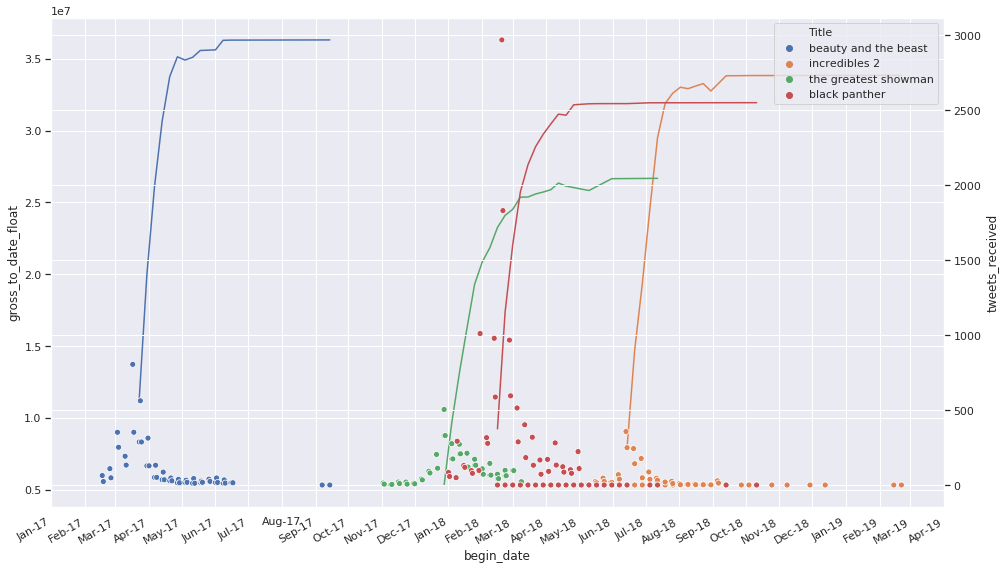

In [28]:
# plot for each movie individually
fig, ax = plt.subplots()

sns.lineplot(x=sub['begin_date'],
            y=sub['gross_to_date_float'],
            ax=ax,
            hue=sub['Title'],
            legend=False);

ax2 = ax.twinx()

sns.scatterplot(x=sub['begin_date'],
               y=sub['tweets_received'],
               ax=ax2,
                hue=sub['Title']);

# Define the date format
fig.autofmt_xdate()
ax.set_xlim([datetime.date(2017, 1, 1), datetime.date(2019, 4, 1)])

date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

### Sentiment of tweets

### Seasonality/Genre/Influencer effecting sales

### Any time series studies?

------------------------------------------------------------------

In [29]:
followers_freq = df_sbuzz['user_followers_count'].value_counts(sort=True, ascending=True).to_dict()

In [30]:
max(followers_freq)

10883460

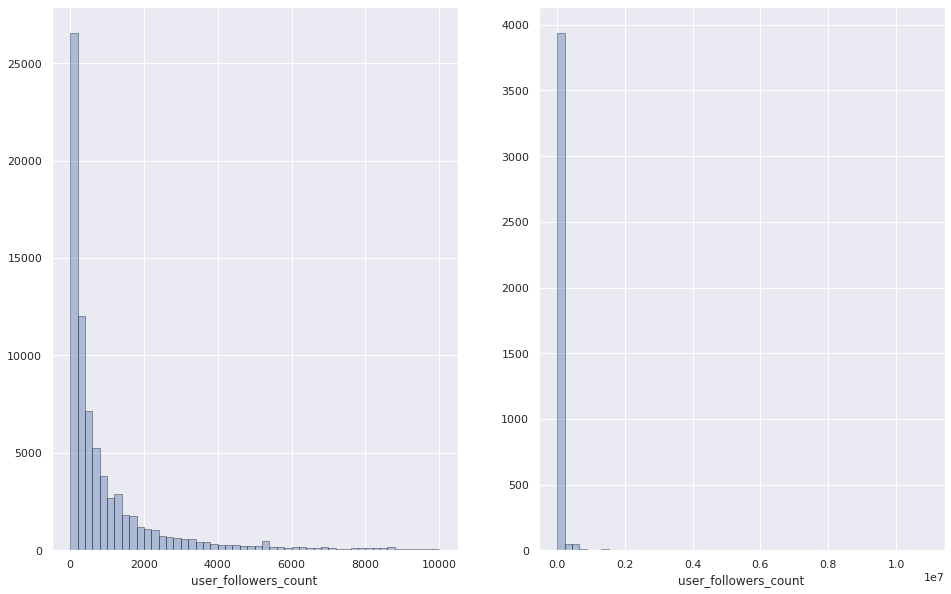

In [31]:
plt.subplot(1, 2, 1)
sns.distplot(df_sbuzz['user_followers_count'][df_sbuzz['is_influencer']==False], kde=False, hist_kws=dict(edgecolor="k"));
plt.subplot(1, 2, 2)
sns.distplot(df_sbuzz['user_followers_count'][df_sbuzz['is_influencer']==True], kde=False, hist_kws=dict(edgecolor="k"));

# there are some outliers with influencer followers count